In [ ]:
from cucim.skimage.color import hsv2rgb, rgb2hsv
import cupy as cp
import numpy as np
from colorsys import hsv_to_rgb, rgb_to_hsv
import matplotlib.pyplot as plt
from segmentation_tools.preprocessing import normalize


In [8]:
img=np.load(r"D:\my_data\W1\20241205 FUCCI halo timelapse col_glass 770k\segmented\C1\C1-130_seg.npy", allow_pickle=True).item()['img']

In [9]:
normalized=normalize(img)

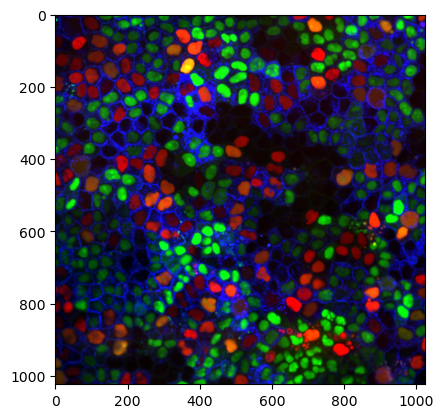

In [10]:
plt.imshow(normalized)

In [20]:
img_8bit = (normalized*255).astype(np.uint8)

In [25]:
def rgb_to_hsv_array(rgb_array):
    # Normalize RGB values to [0, 1]
    rgb_array = rgb_array / 255.0
    
    # Split channels
    r, g, b = rgb_array[..., 0], rgb_array[..., 1], rgb_array[..., 2]

    # Vectorized conversion
    hsv = np.vectorize(rgb_to_hsv)(r, g, b)
    
    # Stack into (M, N, 3) format
    return np.stack(hsv, axis=-1)

def hsv_to_rgb_array(hsv_array):
    # Split channels
    h, s, v = hsv_array[..., 0], hsv_array[..., 1], hsv_array[..., 2]
    
    # Vectorized conversion
    rgb = np.vectorize(hsv_to_rgb)(h, s, v)
    
    # Stack into (M, N, 3) format
    return np.stack(rgb, axis=-1)

In [36]:
%%timeit
hsv=rgb_to_hsv_array(255-normalized)
hsv[...,0]=np.mod(hsv[...,0]+0.5, 1)
rgb=hsv_to_rgb_array(hsv)

1.43 s ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%timeit
hsv=rgb2hsv(255-cp.asarray(img_8bit))
hsv[...,0]=cp.mod(hsv[...,0]+0.5, 1)
rgb=hsv2rgb(hsv).get()

8.66 ms ± 379 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


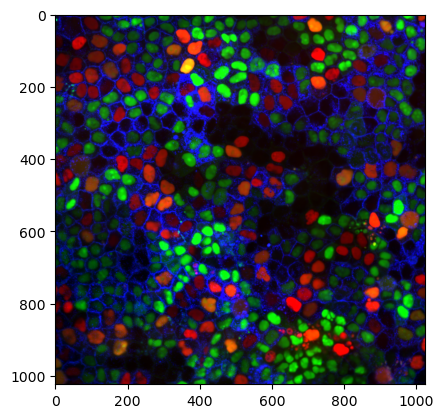

In [90]:
plt.imshow(img_8bit)

In [105]:
hsv.shape

(1024, 1024, 3)

In [110]:
from cv2 import cvtColor, COLOR_RGB2HSV, COLOR_HSV2RGB

hsv=cvtColor(img_8bit, COLOR_RGB2HSV)
hsv[...,2]=255-hsv[...,2]
rgb=cvtColor(hsv, COLOR_HSV2RGB)

In [154]:
def invert_skimage(img):
    cp_img = cp.asarray(img)
    cp.subtract(1, cp_img, out=cp_img)
    hsv = rgb2hsv(cp_img)
    cp.add(hsv[..., 0], 0.5, out=hsv[..., 0])  # In-place hue rotation
    cp.mod(hsv[..., 0], 1, out=hsv[..., 0])  # Ensure values remain in [0,1]
    rgb = hsv2rgb(hsv).get()
    return rgb

import cv2
def invert_cv2(img):
    lut = np.array([255 - i for i in range(256)], dtype=np.uint8)  # Lookup table
    img_inv = cv2.LUT(img, lut)  # Fast inversion
    
    hsv = cv2.cvtColor(img_inv, cv2.COLOR_RGB2HSV)
    hsv[..., 0] = (hsv[..., 0] + 90) % 180  # In-place hue rotation
    
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [157]:
%timeit invert_skimage(img_8bit)
%timeit invert_cv2(img_8bit)

The slowest run took 9.86 times longer than the fastest. This could mean that an intermediate result is being cached.
16.3 ms ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.25 ms ± 149 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


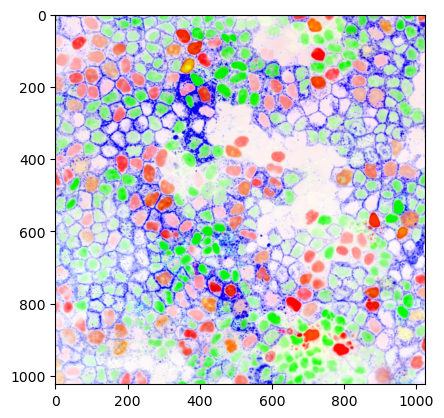

In [149]:
plt.imshow(invert_cv2(img_8bit))

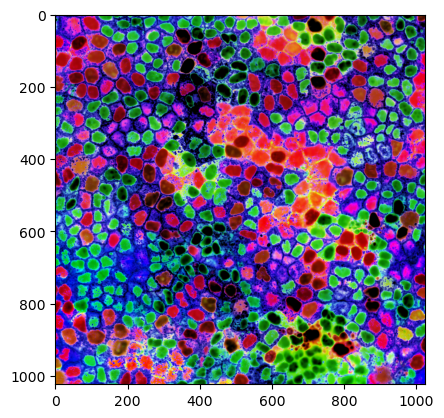

In [121]:
plt.imshow(rgb)